In [1]:
import pandas as pd
import numpy as np
import time
from utils import dfwellgr,marker_ssig,extract_signature_Xy,get_classifier,plot_simple
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(42)

In [3]:
#Import For Classification 
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#Import For Testing 
from utils import window, plot_pred_distribution
from prediction import apply_fit_distribution,get_markers_rocket_order_with_constraint
from utils import apply_evaluate

from IPython.display import clear_output
import statistics

In [37]:
def run_prediction(myrocket,intervals,df_test_tops, df_test_log, use_constraint=True,confidence_level=0.96,verbose=0):
    start = time.time()
    df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))
    for well in tqdm(df_test_tops.index, desc=f"Processing Wells"):
        pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = False,
                                             model = None, 
                                             xgb = True,
                                             rocket = myrocket, 
                                             classifier_xgb = classifier_xgb, 
                                             classifier = classifier,
                                             constraint = use_constraint,
                                            )
        row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
        row_df = pd.DataFrame([row])
        df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")
        
    ext = time.time() - start
    print(f'🍺 Total prediction time {ext}')
    df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
    df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
    df_tops_pred = df_tops_pred.set_index('wellName')
    return df_tops_pred

### LOAD Data and Testing Data

In [6]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

In [32]:
#Load Testing Data 100 WELLS
df_test_log100 = pd.read_parquet('testdata/logs_100.parquet', engine='fastparquet')
df_test_log100.loc[df_test_log100['GR'] < -1, 'GR' ] = -1
df_test_log100.loc[df_test_log100['GR'] > 400, 'GR' ] = 400

df_test_loc100 = pd.read_parquet('testdata/loc_100.parquet', engine='fastparquet')
df_test_loc100 = df_test_loc100.reset_index()

df_test_log100 = df_test_loc100.merge(df_test_log100, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops100 = pd.read_csv('testdata/tops_100.csv')
df_test_tops100 = df_test_tops100.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops100 = df_test_tops100[cols]

In [40]:
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)

In [42]:
marcel = df_tops[df_tops.index.isin(well_array[0][0])]['MARCEL']

In [ ]:
for i, marker in enumerate(markers):

In [74]:
interval_records = {
    'MARCEL':[],
    'SYLVAIN':[],
    'CONRAD':[]
}
methods = ['gausian','neo-log','fft','cauchy','cauchy-fft']
markers = ['MARCEL','SYLVAIN','CONRAD']
intervals = []

for i in methods:
    interval = apply_fit_distribution(df_tops,well_array,method=i)
    intervals.append(interval)
    for marker in markers:
        interval_records[marker].append(interval[marker])

gausian Stable Distribution 🍺 Total Time 36.15134882926941
MARCEL    5900.0 6838.0 (938.0m)
SYLVAIN   6151.0 7010.0 (859.0m)
CONRAD    6189.0 7033.0 (844.0m)
neo-log Stable Distribution 🍺 Total Time 263.675950050354
MARCEL    6071.0 6631.0 (560.0m)
SYLVAIN   6333.0 6903.0 (570.0m)
CONRAD    6367.0 6923.0 (555.0m)
fft Stable Distribution 🍺 Total Time 0.11003804206848145
MARCEL    6126.0 6673.0 (548.0m)
SYLVAIN   6363.0 6929.0 (566.0m)
CONRAD    6390.0 6957.0 (568.0m)
cauchy Stable Distribution 🍺 Total Time 0.01753091812133789
MARCEL    5412.0 7456.0 (2044.0m)
SYLVAIN   5617.0 7764.0 (2147.0m)
CONRAD    5624.0 7812.0 (2188.0m)
cauchy-fft Stable Distribution 🍺 Total Time 0.008091926574707031
MARCEL    5211.0 7654.0 (2443.0m)
SYLVAIN   5373.0 7996.0 (2624.0m)
CONRAD    5366.0 8053.0 (2687.0m)


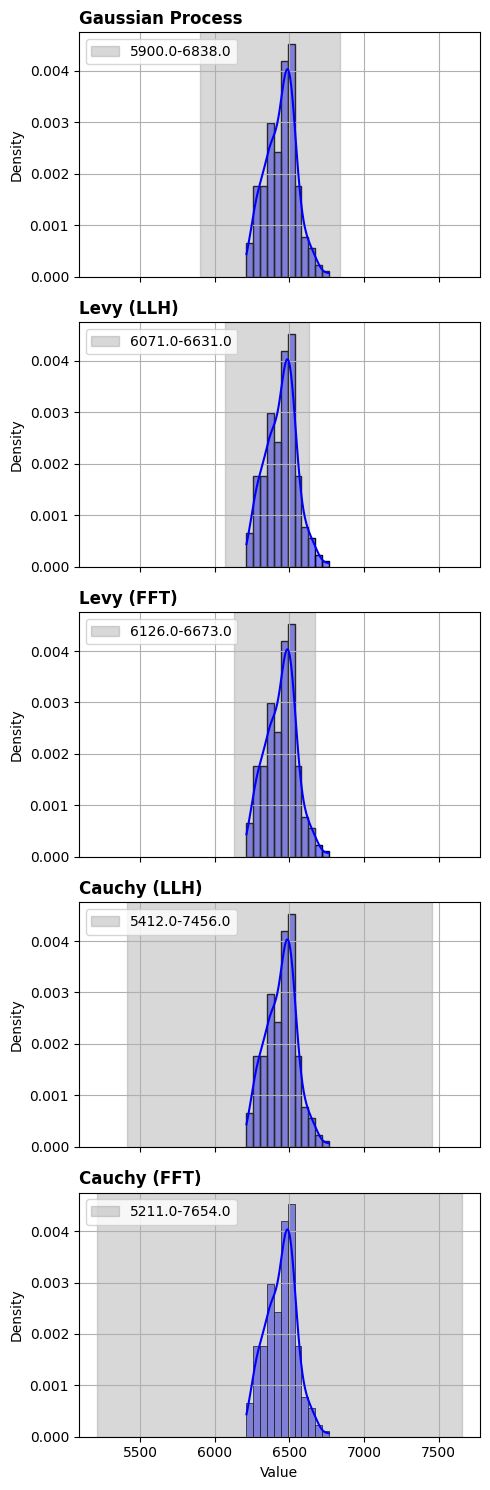

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


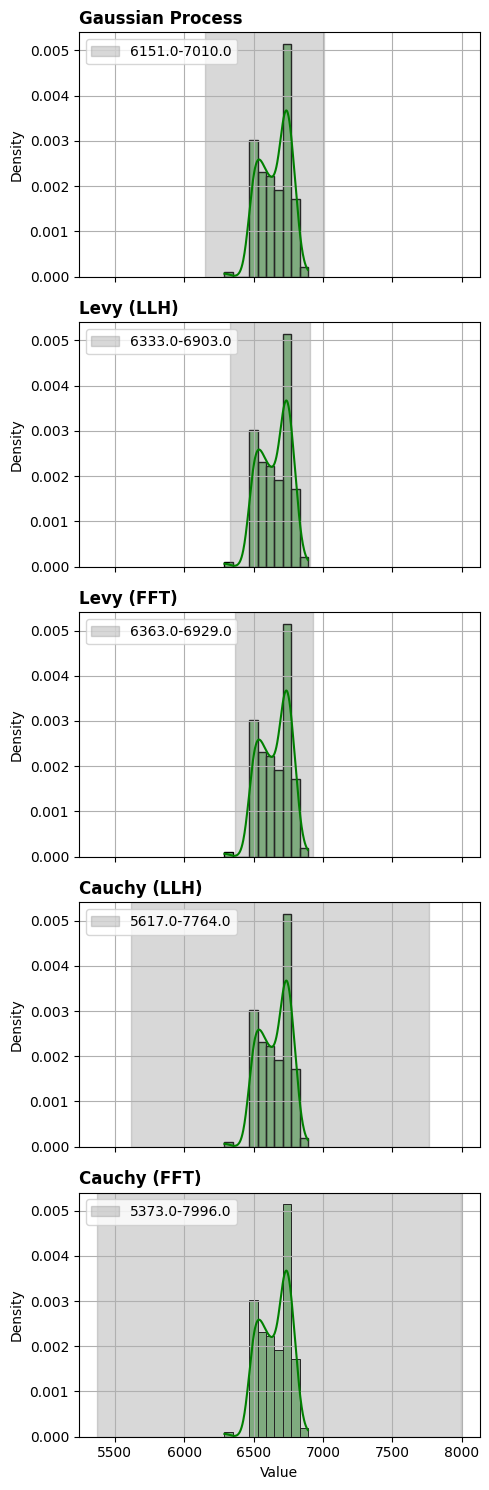

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


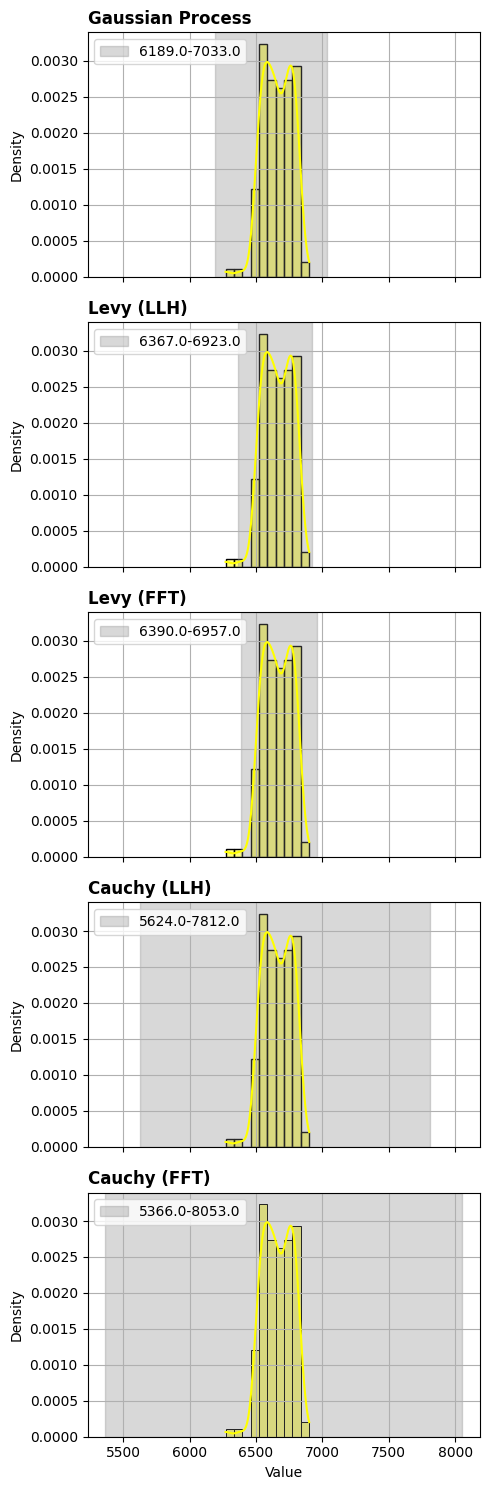

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [110]:
# Plotting individual distribution plots for each interval
colors = ['blue','green','yellow']
for a,marker in enumerate(markers):
    fig, axes = plt.subplots(5, 1, figsize=(5, 15), sharex=True)

    df = df_tops[df_tops.index.isin(well_array[a][0])][marker]

    for i, (start, end) in enumerate(interval_records[marker]):
        # Histogram with KDE
        sns.histplot(df.values, kde=True,color=colors[a],stat='density', ax=axes[i])
        
        # Plotting the interval
        axes[i].axvspan(start, end, color='grey', alpha=0.3, label=f'{round(start,0)}-{round(end,0)}')
        
        axes[i].set_title(f'{labels[i]}',loc='left',fontweight='bold')
        axes[i].set_xlabel('Depth')
        axes[i].set_ylabel('Density')
        axes[i].legend(fontsize=10,loc='upper left')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
    print("- -"*20)


### 

### Mini ROCKET

The evolution of ROCKET, MINIROCKET [6], is proposed as the new default variant of ROCKET by its authors and utilizes only one feature per kernel (percentage of positive values), thereby halving the features. It also utilizes other optimizations to speed up ROCKET in general and follows a minimally random approach with a given set of kernels

In [29]:
from sktime.transformations.panel.rocket import MiniRocket

In [30]:
#Load Prepared Data
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,y_train = X,y
minirocket = MiniRocket(num_kernels=10000) 
minirocket.fit(X_train) 

start = time.time()
X_train_transformed = minirocket.transform(X_train) 
et = time.time() - start
print(f'Transforming time for mini ROCKET: {et}')

X_test_transformed = minirocket.transform(X_test) 

Transforming time for mini ROCKET: 2.011644124984741


In [38]:
f_mean, f_std, classifier_xgb, classifier = get_classifier(X_train_transformed,y_train,X_test_transformed,y_test)

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(minirocket,interval,df_test_tops,df_test_log, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

XGBoost 1.0
Logistic  1 eps: 1.00E-06  C: 1.00E-02   train_acc: 1.00000  valid_acc: 1.00000
😈gausian😈


Processing Wells: 100%|██████████| 50/50 [03:08<00:00,  3.78s/it]


🍺 Total prediction time 188.77099919319153
tolerance 20, recall 0.9866666666666667, mae 4.18
tolerance 15, recall 0.9666666666666667, mae 4.18
tolerance 10, recall 0.9133333333333333, mae 4.18
tolerance 5, recall 0.7466666666666667, mae 4.18
Largest Error MARCEL: 32.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 32
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


🍺 Total prediction time 194.33051896095276
tolerance 20, recall 0.9466666666666667, mae 7.463333333333333
tolerance 15, recall 0.94, mae 7.463333333333333
tolerance 10, recall 0.8866666666666667, mae 7.463333333333333
tolerance 5, recall 0.7266666666666667, mae 7.463333333333333
Largest Error MARCEL: 66.0
Largest Error SYLVAIN: 169.0
Largest Error CONRAD: 43.0
🍺 Optimal Tolerance : 169
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [03:29<00:00,  4.19s/it]


🍺 Total prediction time 209.70168590545654
tolerance 20, recall 0.9733333333333334, mae 4.3533333333333335
tolerance 15, recall 0.96, mae 4.3533333333333335
tolerance 10, recall 0.9066666666666666, mae 4.3533333333333335
tolerance 5, recall 0.7466666666666667, mae 4.3533333333333335
Largest Error MARCEL: 32.0
Largest Error SYLVAIN: 29.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 32
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [03:20<00:00,  4.02s/it]


🍺 Total prediction time 200.9605770111084
tolerance 20, recall 0.9866666666666667, mae 4.18
tolerance 15, recall 0.9666666666666667, mae 4.18
tolerance 10, recall 0.9133333333333333, mae 4.18
tolerance 5, recall 0.7466666666666667, mae 4.18
Largest Error MARCEL: 32.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 32
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [04:05<00:00,  4.91s/it]

🍺 Total prediction time 245.39720916748047
tolerance 20, recall 0.9866666666666667, mae 4.18
tolerance 15, recall 0.9666666666666667, mae 4.18
tolerance 10, recall 0.9133333333333333, mae 4.18
tolerance 5, recall 0.7466666666666667, mae 4.18
Largest Error MARCEL: 32.0
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 32
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


### MultiROCKET

In [9]:
from rocket.multi_rocket.multirocket import MultiRocket

In [10]:
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [21]:
num_kernels = [500,1000,2000]
xgb = [True, False]

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']


multirocket = MultiRocket(
    num_kernels=1000
)
multirocket.fit(X_train)

start = time.time()
X_train_transformed = multirocket.transform(X_train)
et = time.time() - start
print(f'Transforming time for ROCKET: {et}')

X_test_transformed = multirocket.transform(X_test) 

f_mean, f_std, classifier_xgb, classifier = get_classifier(X_train_transformed,y_train,X_test_transformed,y_test)

for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(multirocket,interval,df_test_tops,df_test_log, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)


Transforming time for ROCKET: 0.8213198184967041
XGBoost 0.998812351543943
Logistic  1 eps: 1.00E-06  C: 1.00E-02   train_acc: 1.00000  valid_acc: 1.00000
😈gausian😈


Processing Wells: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


🍺 Total prediction time 75.20873093605042
tolerance 20, recall 1.0, mae 3.716666666666667
tolerance 15, recall 0.9933333333333333, mae 3.716666666666667
tolerance 10, recall 0.9466666666666667, mae 3.716666666666667
tolerance 5, recall 0.7666666666666667, mae 3.716666666666667
Largest Error MARCEL: 13.0
Largest Error SYLVAIN: 15.0
Largest Error CONRAD: 18.0
🍺 Optimal Tolerance : 18
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


🍺 Total prediction time 74.41244912147522
tolerance 20, recall 0.96, mae 6.96
tolerance 15, recall 0.9533333333333334, mae 6.96
tolerance 10, recall 0.9133333333333333, mae 6.96
tolerance 5, recall 0.74, mae 6.96
Largest Error MARCEL: 88.0
Largest Error SYLVAIN: 149.0
Largest Error CONRAD: 66.0
🍺 Optimal Tolerance : 149
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


🍺 Total prediction time 67.27034902572632
tolerance 20, recall 0.9866666666666667, mae 4.81
tolerance 15, recall 0.9733333333333334, mae 4.81
tolerance 10, recall 0.9333333333333333, mae 4.81
tolerance 5, recall 0.76, mae 4.81
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 149.0
Largest Error CONRAD: 18.0
🍺 Optimal Tolerance : 149
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


🍺 Total prediction time 68.436607837677
tolerance 20, recall 1.0, mae 3.716666666666667
tolerance 15, recall 0.9933333333333333, mae 3.716666666666667
tolerance 10, recall 0.9466666666666667, mae 3.716666666666667
tolerance 5, recall 0.7666666666666667, mae 3.716666666666667
Largest Error MARCEL: 13.0
Largest Error SYLVAIN: 15.0
Largest Error CONRAD: 18.0
🍺 Optimal Tolerance : 18
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

🍺 Total prediction time 66.41861581802368
tolerance 20, recall 1.0, mae 3.716666666666667
tolerance 15, recall 0.9933333333333333, mae 3.716666666666667
tolerance 10, recall 0.9466666666666667, mae 3.716666666666667
tolerance 5, recall 0.7666666666666667, mae 3.716666666666667
Largest Error MARCEL: 13.0
Largest Error SYLVAIN: 15.0
Largest Error CONRAD: 18.0
🍺 Optimal Tolerance : 18
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


### LightWaveS

In [22]:
from rocket.lightwaves.lightwaves import LightWaveS

[wangyuchens-MBP.lan:82285] shmem: mmap: an error occurred while determining whether or not /var/folders/gj/m7pys2v95k19_b1dkf01nl5r0000gn/T//ompi.wangyuchens-MBP.501/jf.0/868810752/sm_segment.wangyuchens-MBP.501.33c90000.0 could be created.


In [23]:
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:

lightwaves = LightWaveS(final_num_feat=i)
lightwaves.fit(X_train.astype(np.float32),y_train)

In [28]:
num_feat = 1000

wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']


lightwaves = LightWaveS(final_num_feat=num_feat)
lightwaves.fit(X_train.astype(np.float32),y_train)

start = time.time()
X_train_transformed = lightwaves.transform(X_train)
et = time.time() - start
print(f'Transforming time for ROCKET: {et}')

X_test_transformed = lightwaves.transform(X_test) 

f_mean, f_std, classifier_xgb, classifier = get_classifier(X_train_transformed,y_train,X_test_transformed,y_test)


for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(lightwaves,interval,df_test_tops,df_test_log, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)


Transforming time for ROCKET: 0.6586811542510986
XGBoost 0.997624703087886
Logistic  1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99851  valid_acc: 0.99525
😈gausian😈


Processing Wells: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


🍺 Total prediction time 74.74860692024231
tolerance 20, recall 0.9933333333333333, mae 2.6766666666666667
tolerance 15, recall 0.9866666666666667, mae 2.6766666666666667
tolerance 10, recall 0.9733333333333334, mae 2.6766666666666667
tolerance 5, recall 0.9133333333333333, mae 2.6766666666666667
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 10.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 22
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


🍺 Total prediction time 74.08672189712524
tolerance 20, recall 0.9533333333333334, mae 4.91
tolerance 15, recall 0.9466666666666667, mae 4.91
tolerance 10, recall 0.9333333333333333, mae 4.91
tolerance 5, recall 0.8866666666666667, mae 4.91
Largest Error MARCEL: 98.0
Largest Error SYLVAIN: 63.0
Largest Error CONRAD: 50.0
🍺 Optimal Tolerance : 98
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


🍺 Total prediction time 73.56202816963196
tolerance 20, recall 0.98, mae 2.99
tolerance 15, recall 0.9666666666666667, mae 2.99
tolerance 10, recall 0.9533333333333334, mae 2.99
tolerance 5, recall 0.9, mae 2.99
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 28.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 28
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


🍺 Total prediction time 73.26333999633789
tolerance 20, recall 0.9933333333333333, mae 2.6766666666666667
tolerance 15, recall 0.9866666666666667, mae 2.6766666666666667
tolerance 10, recall 0.9733333333333334, mae 2.6766666666666667
tolerance 5, recall 0.9133333333333333, mae 2.6766666666666667
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 10.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 22
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [01:13<00:00,  1.46s/it]

🍺 Total prediction time 73.1543219089508
tolerance 20, recall 0.9933333333333333, mae 2.6766666666666667
tolerance 15, recall 0.9866666666666667, mae 2.6766666666666667
tolerance 10, recall 0.9733333333333334, mae 2.6766666666666667
tolerance 5, recall 0.9133333333333333, mae 2.6766666666666667
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 10.0
Largest Error CONRAD: 12.0
🍺 Optimal Tolerance : 22
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


In [33]:
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(lightwaves,interval,df_test_tops100,df_test_log100, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops100,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells:   5%|▌         | 5/100 [00:07<02:18,  1.46s/it]


KeyboardInterrupt: 